In [5]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import numpy as np
import scipy.io as spio
import scipy as sp
from scipy.stats import pearsonr,binom,linregress

In [29]:
def pairwise_corr_all(ground_truth, predictions):
    r = np.corrcoef(ground_truth, predictions)#cosine_similarity(ground_truth, predictions)#
    r = r[:len(ground_truth), len(ground_truth):]  # rows: groundtruth, columns: predicitons
    #print(r.shape)
    # congruent pairs are on diagonal
    congruents = np.diag(r)
    #print(congruents)
    
    # for each column (predicition) we should count the number of rows (groundtruth) that the value is lower than the congruent (e.g. success).
    success = r < congruents
    success_cnt = np.sum(success, 0)
    
    # note: diagonal of 'success' is always zero so we can discard it. That's why we divide by len-1
    perf = np.mean(success_cnt) / (len(ground_truth)-1)
    p = 1 - binom.cdf(perf*len(ground_truth)*(len(ground_truth)-1), len(ground_truth)*(len(ground_truth)-1), 0.5)
    
    return perf, p

def pairwise_corr_individuals(ground_truth, predictions):
    r = np.corrcoef(ground_truth, predictions)#cosine_similarity(ground_truth, predictions)#
    r = r[:len(ground_truth), len(ground_truth):]  # rows: groundtruth, columns: predicitons
    #print(r.shape)
    # congruent pairs are on diagonal
    congruents = np.diag(r)
    #print(congruents)
    
    # for each column (predicition) we should count the number of rows (groundtruth) that the value is lower than the congruent (e.g. success).
    success = r < congruents
    success_cnt = np.sum(success, 0)
    
    # note: diagonal of 'success' is always zero so we can discard it. That's why we divide by len-1
    perf = success_cnt / (len(ground_truth)-1)
    # p = 1 - binom.cdf(perf*len(ground_truth)*(len(ground_truth)-1), len(ground_truth)*(len(ground_truth)-1), 0.5)
    
    return perf


net_list = [
    ('inceptionv3','avgpool'),
    ('clip','final'),
    ('alexnet',2),
    ('alexnet',5),
    ('efficientnet','avgpool'),
    ('swav','avgpool')
    ]

num_test = 200
test_dir = '../cache/thingseeg2_preproc/eval_features/test_images'
feats_dir = '../cache/thingseeg2_preproc/eval_features/subj1_preproc_800ms'
distance_fn = sp.spatial.distance.correlation
pairwise_corrs = []
for (net_name,layer) in net_list:
    file_name = '{}/{}_{}.npy'.format(test_dir,net_name,layer)
    gt_feat = np.load(file_name)
    
    file_name = '{}/{}_{}.npy'.format(feats_dir,net_name,layer)
    eval_feat = np.load(file_name)
    
    gt_feat = gt_feat.reshape((len(gt_feat),-1))
    eval_feat = eval_feat.reshape((len(eval_feat),-1))

    print(net_name,layer)
    if net_name in ['efficientnet','swav']:
        print('distance: ',np.array([distance_fn(gt_feat[i],eval_feat[i]) for i in range(num_test)]).mean())
    else:
        # pairwise_corrs.append(pairwise_corr_all(gt_feat[:num_test],eval_feat[:num_test])[0])
        pairwise_corrs.append(pairwise_corr_individuals(gt_feat[:num_test],eval_feat[:num_test]))

clip_corrs = pairwise_corrs[1]
normalized_clip_corrs = (clip_corrs - np.mean(clip_corrs)) / np.std(clip_corrs)
# Apply sigmoid function
sigmoid_normalized_clip_corrs = 1 / (1 + np.exp(-normalized_clip_corrs))

inceptionv3 avgpool
clip final
alexnet 2
alexnet 5
efficientnet avgpool
distance:  0.9121800053943298
swav avgpool
distance:  0.5758596473932266


In [17]:
import os
import cv2
import numpy as np
from imageio import imread
from skimage.transform import resize
import re

# Specify the folder
folder = '../results/thingseeg2_preproc/versatile_diffusion_800ms'

# Get the names of all files in the folder
filenames = os.listdir(folder)

# Function to convert a string to number if possible
def tryint(s):
    try:
        return int(s)
    except:
        return s

# Function to sort filenames with numbers
def alphanum_key(s):
    return [tryint(c) for c in re.split('([0-9]+)', s)]

# Sort filenames
filenames.sort(key=alphanum_key)

# Initialize an empty list to store the images
recon_images = []

# Load each image and add it to the list
for filename in filenames:
    # Only load files that are images
    if filename.endswith('.png') or filename.endswith('.jpg'):
        img = imread(os.path.join(folder, filename))
        
        # Convert the image to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize the image
        img_resized = resize(img_rgb, (500, 500))
        img_resized = (img_resized * 255).astype(np.uint8)
        
        recon_images.append(img_resized)

# Convert the list of images into a numpy array
recon_images = np.array(recon_images)
print(recon_images.shape)

/tmp/ipykernel_3415563/3391872319.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(os.path.join(folder, filename))


(200, 500, 500, 3)


In [8]:
test_clip = np.load('../cache/thingseeg2_preproc/eval_features/test_images/clip_final.npy')
pred_clip = np.load('../cache/thingseeg2_preproc/eval_features/subj1_preproc_800ms/clip_final.npy')
test_images = np.load('../data/things-eeg2_preproc/test_images.npy')

# test_clip = test_clip.reshape(test_clip.shape[0], -1)
# pred_clip = pred_clip.reshape(pred_clip.shape[0], -1)
combined = np.concatenate((test_clip, pred_clip), axis=0)
test_clip.shape, pred_clip.shape, combined.shape, test_images.shape

((200, 768), (200, 768), (400, 768), (200, 500, 500, 3))

In [11]:
reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(combined)

/mnt/sphere/projects/simon/visual-reconstruction/diffusion/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[]

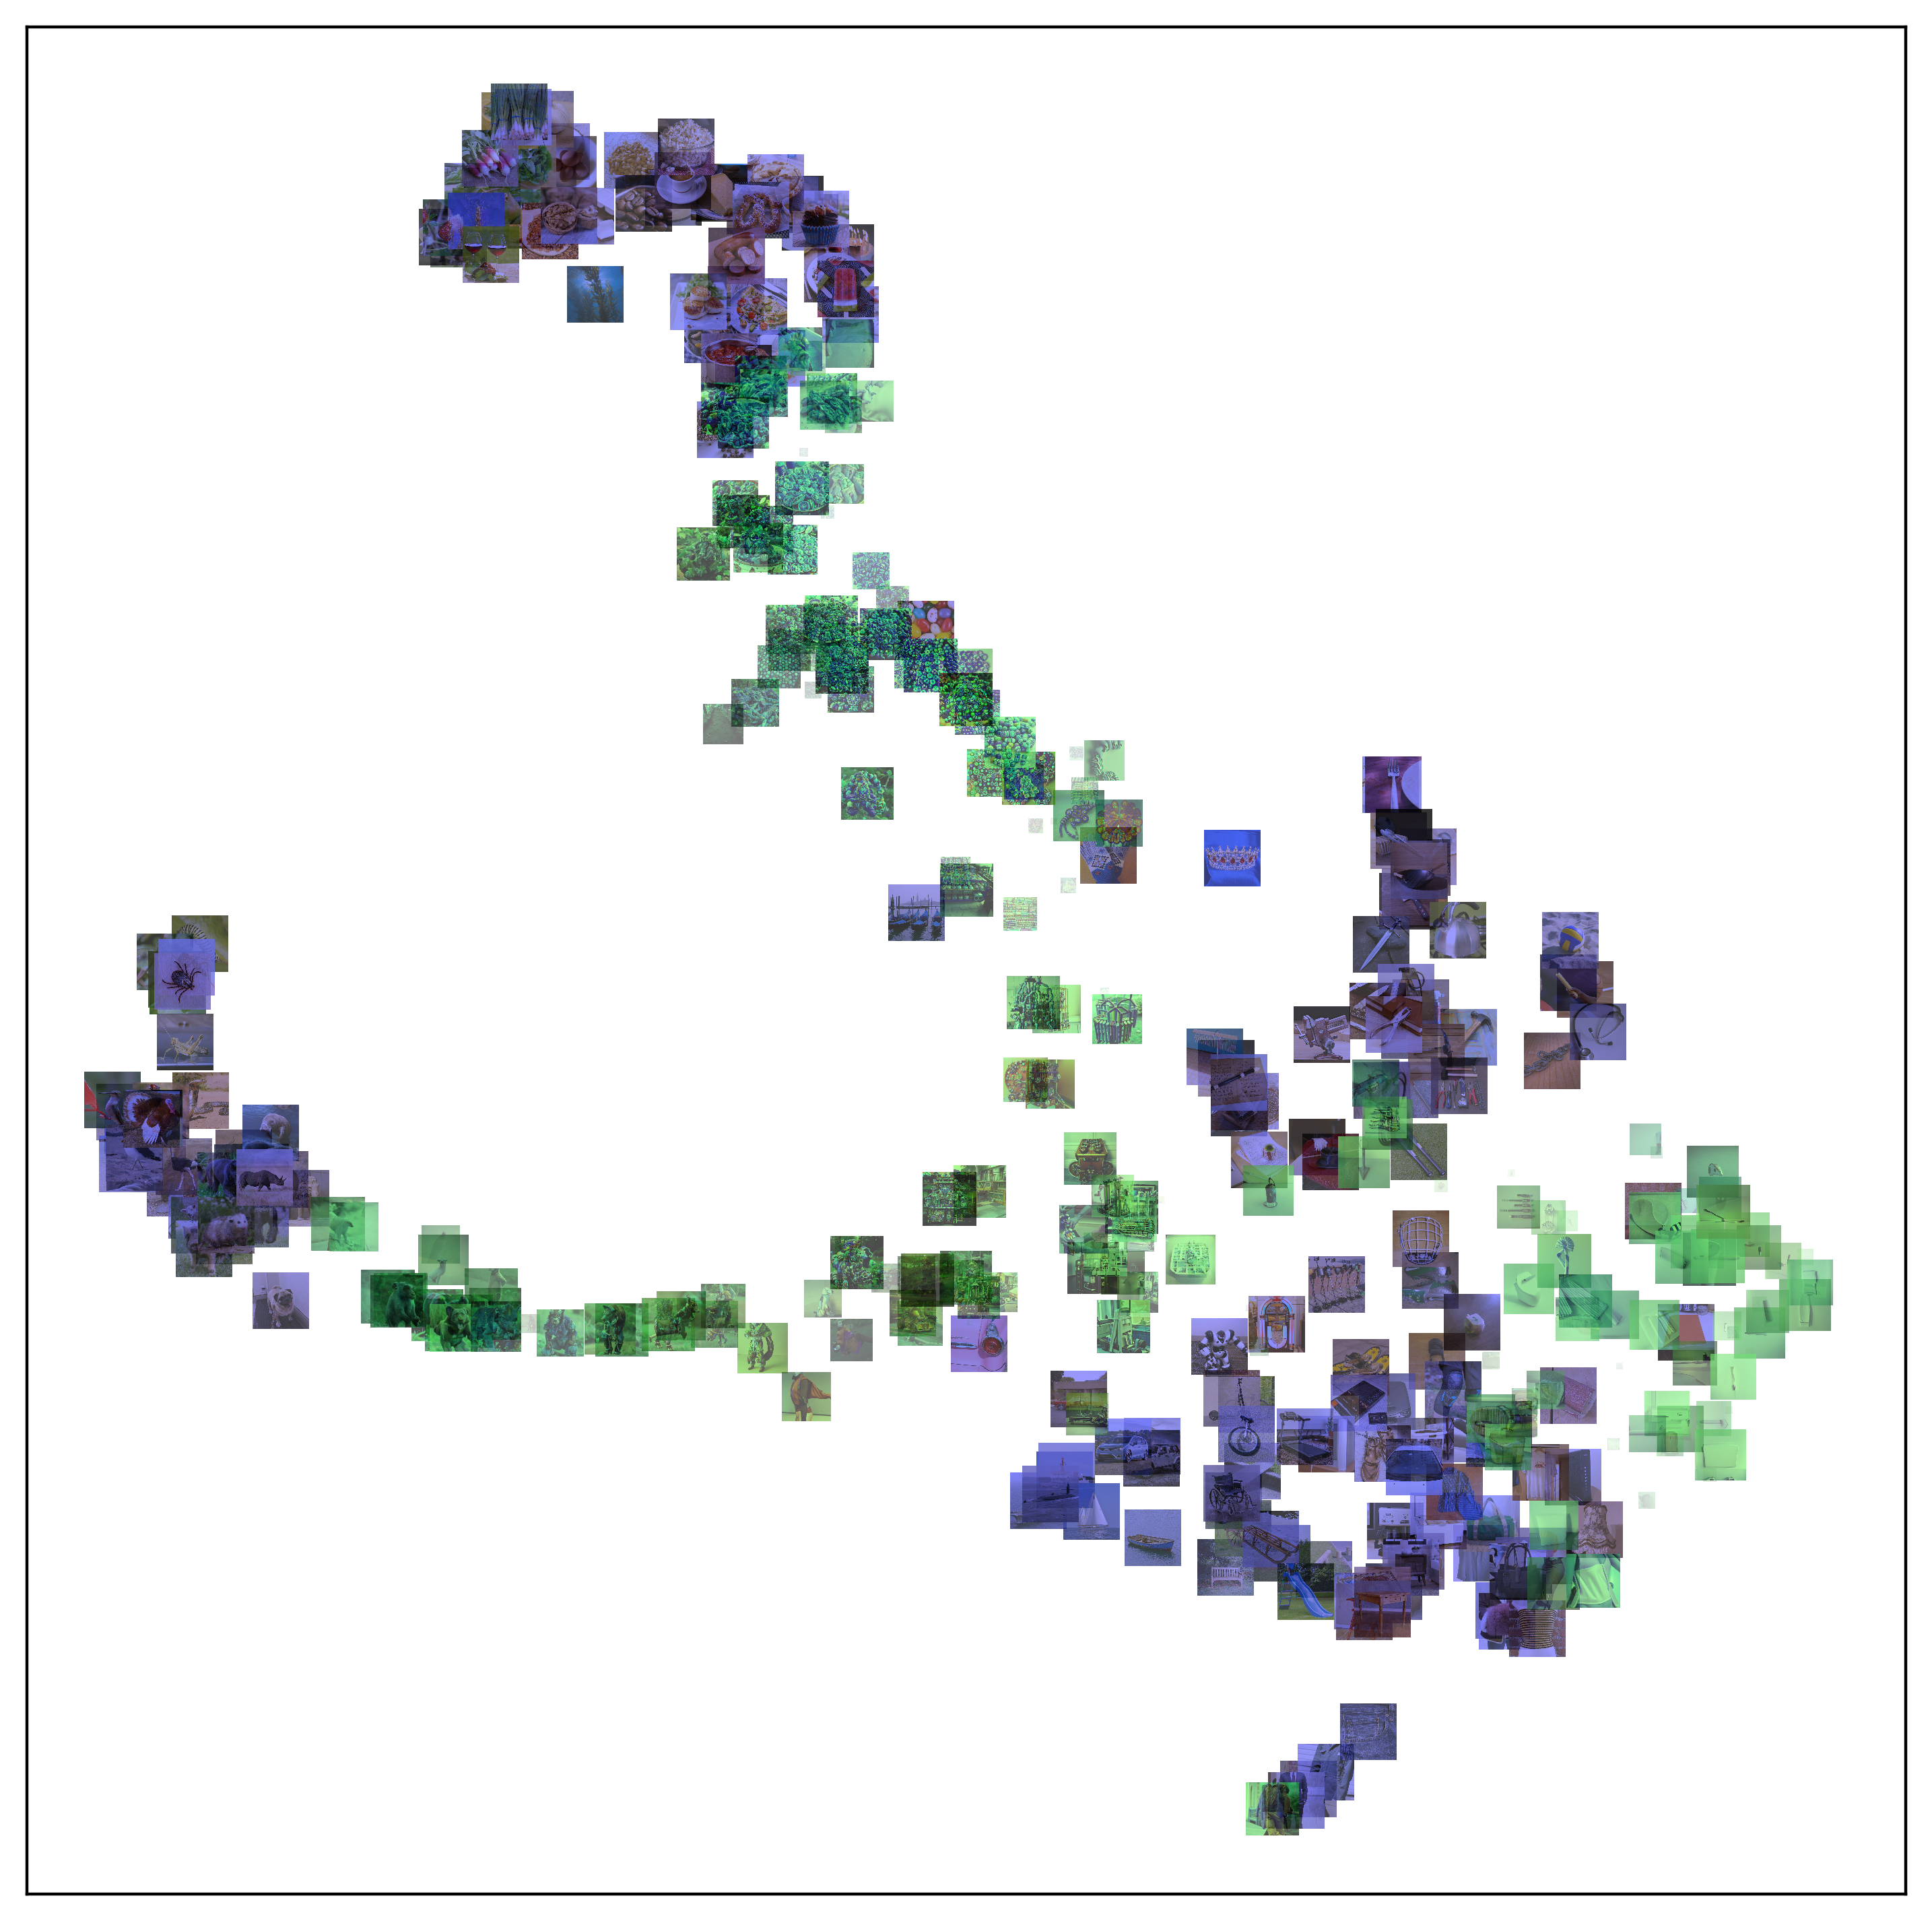

In [32]:
fig, ax = plt.subplots(figsize=(9, 9), dpi=400)
ax.scatter(embedding[:, 0],
            embedding[:, 1], alpha=0)

for i in range(len(test_images)):
    im = Image.fromarray(test_images[i].astype(np.uint8))
    # red, green, blue = im.split()
    # filtered_red = red.point(lambda i: i * 0.5)
    # filtered_green = green.point(lambda i: i * 0.5)
    # zeroed_blue = blue.point(lambda _: 0)
    # im = Image.merge("RGB", (filtered_red, filtered_green, blue))
    matrix = ( 0.5, 0,  0, 0, 
           0,   0.5,  0, 0, 
           0,   0,  1, 0)
    im = im.convert("RGB", matrix) 
    offset_im = OffsetImage(im, zoom=.03, alpha = 0.8)
    ab = AnnotationBbox(offset_im, (embedding[i, 0], embedding[i, 1]), frameon=False)
    ax.add_artist(ab)

for i in range(len(recon_images)):
    im = Image.fromarray(recon_images[i].astype(np.uint8))
    matrix = ( 0.5, 0,  0, 0, 
           0,   1,  0, 0, 
           0,   0,  0.5, 0)
    im = im.convert("RGB", matrix) 
    offset_im = OffsetImage(im, zoom=.04 * sigmoid_normalized_clip_corrs[i], alpha = sigmoid_normalized_clip_corrs[i])
    ab = AnnotationBbox(offset_im, (embedding[i + len(recon_images), 0], embedding[i + len(recon_images), 1]), frameon=False)
    ax.add_artist(ab)

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])